<h1><center>Cō Vidis?</center></h1>

<center><b>Cō Vidis?</b> [kʷoː ˈwɪːdɪs] ➡️ latin for "COVID-19, where are you going?"<br/>
Follow the state of the Coronavirus with a focus on Switzerland 🇨🇭.</center>

## Imports

In [1]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import geoplot as gplt
import mapclassify as mc
import reverse_geocoder as rg
import countrynames
sns.set(style="whitegrid")
%config InlineBackend.figure_format ='retina'

# The command to generate the HTML
# jupyter nbconvert covid-19.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --TagRemovePreprocessor.remove_input_tags='{"remove_input"}'

## Functions

In [2]:
def create_by_country_dataframe(df):
    by_country = df.T
    by_country.columns = by_country.loc["Country/Region"]
    by_country = by_country[4:]
    by_country = by_country.groupby(axis=1, by=by_country.columns).sum()
    by_country.index = pd.to_datetime(by_country.index)
    return by_country

def add_alpha_3(df):
    #df = pd.DataFrame(df.sum(axis=0))
    #df = df.rename(columns={0:"Cases"})
    #df = df.reset_index()
    return pd.merge(df, df_countries_code, on="Country/Region")  

def round_up(x):
    return int(math.ceil(x / 100.0)) * 100

def is_it_spreading(df):
    return df.diff()

## Data Loading

In [3]:
data = "../data/raw/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/"
countries = "../data/external/countries.csv"

In [4]:
confirmed = f"{data}time_series_covid19_confirmed_global.csv"
deaths = f"{data}time_series_covid19_deaths_global.csv"
recovered = f"{data}time_series_covid19_recovered_global.csv"

In [5]:
df_confirmed = pd.read_csv(confirmed)
df_deaths = pd.read_csv(deaths)
df_recovered = pd.read_csv(recovered)
df_countries = pd.read_csv(countries)

In [6]:
df = {
    "confirmed": df_confirmed,
    "deaths": df_deaths,
    "recovered": df_recovered
}

df_country_codes = df_countries[["name", "alpha-3", "alpha-2"]]
df_country_codes = df_country_codes.rename(columns={"name": 'Country/Region'})

## Compute a Index by Country

In [7]:
by_country = {
    "confirmed" : create_by_country_dataframe(df.get("confirmed")),
    "deaths" : create_by_country_dataframe(df.get("deaths")),
    "recovered" : create_by_country_dataframe(df.get("recovered"))
}

Compute the existing cases and add them to the Dictionnary

In [8]:
# Active cases = total confirmed - total recovered - total deaths
by_country["existing"] = by_country["confirmed"] - by_country["recovered"] - by_country["deaths"]

## Regions of Interest

In [9]:
CH = ["Switzerland"]
CH_neighbors = ["Italy", "France", "Liechtenstein", "Austria", "Germany"]
CH_neighbors_no_italy = ["France", "Liechtenstein", "Austria", "Germany"]

# Bulgaria, Cyprus and Romania are not in the list
# Switzerland has been added
EU = ["Switzerland","Austria","Belgium","Croatia","Denmark","Estonia","Finland","France","Germany","Greece","Hungary","Ireland","Italy","Latvia","Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden"]
EU_no_italy = ["Switzerland","Austria","Belgium","Croatia","Denmark","Estonia","Finland","France","Germany","Greece","Hungary","Ireland","Latvia","Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden"]

## Period of Interest

In [10]:
last_n_days = 14

In [11]:
existing = by_country.get("existing")[-last_n_days:]
confirmed = by_country.get("confirmed")[-last_n_days:]
deaths = by_country.get("deaths")[-last_n_days:]
recovered = by_country.get("recovered")[-last_n_days:]

## Switzerland

In [12]:
# Linear Regression
df = existing[CH].diff()[1:]
X = df.index.factorize()[0].reshape(-1,1)
Y = df.values
m = LinearRegression().fit(X, Y)
Y_pred = m.predict(X)
Y_pred = pd.DataFrame(Y_pred)
Y_pred.index = df.index
Y_pred = Y_pred.rename(columns={0:"Trend"})

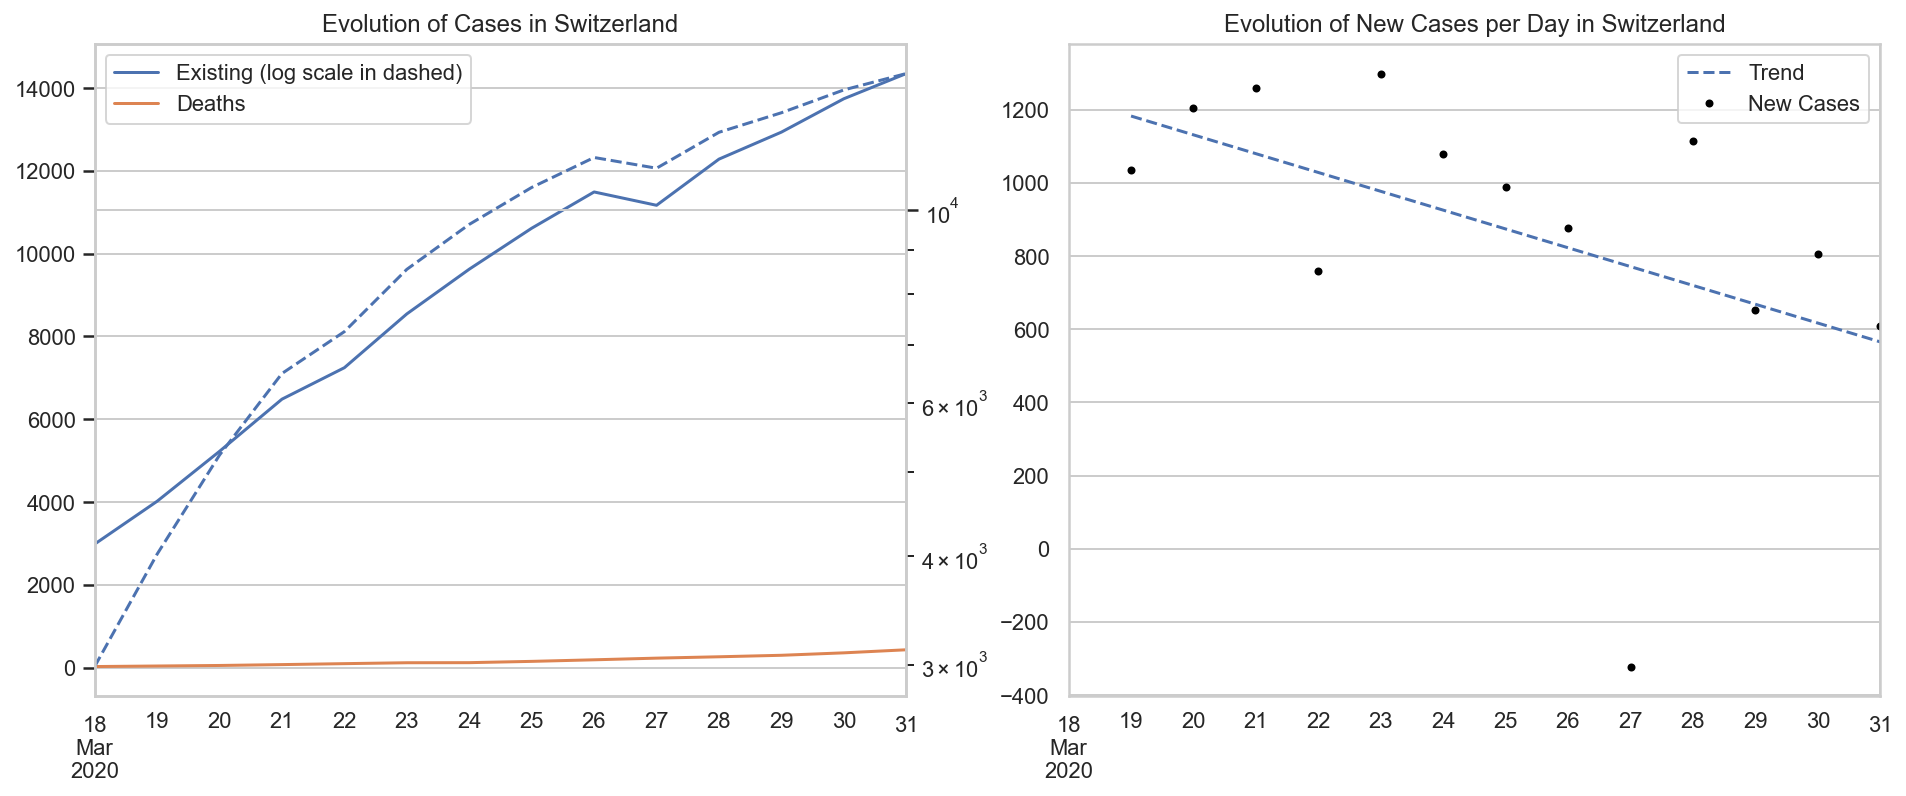

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2)
    
ax1 = existing[CH].sum(axis=1).plot(ax=ax1, title="Evolution of Cases in Switzerland")
ax1 = deaths[CH].sum(axis=1).plot(ax=ax1)
ax1log = ax1.twinx()
ax1log = existing[CH].sum(axis=1).plot(ax=ax1log, logy=True, style="--")

Y_pred.plot(ax=ax2, figsize=(16,6), style="--");
existing[CH].diff().plot(ax=ax2, style=".", color="black", title="Evolution of New Cases per Day in Switzerland");

ax1.legend(["Existing (log scale in dashed)", "Deaths"]);
ax2.legend(["Trend", "New Cases"]);

## Neighboring Countries

In [14]:
df1 = pd.DataFrame(by_country["existing"][CH_neighbors + CH].iloc[-1].astype(int))
df2 = pd.DataFrame(by_country["deaths"][CH_neighbors + CH].iloc[-1].astype(int))
df1.rename(columns={df1.columns[-1]:"Existing"}, inplace=True)
df2.rename(columns={df2.columns[-1]:"Deaths"}, inplace=True)
df = pd.concat([df1,df2], axis=1)
df = df.sort_values("Existing", ascending=False)

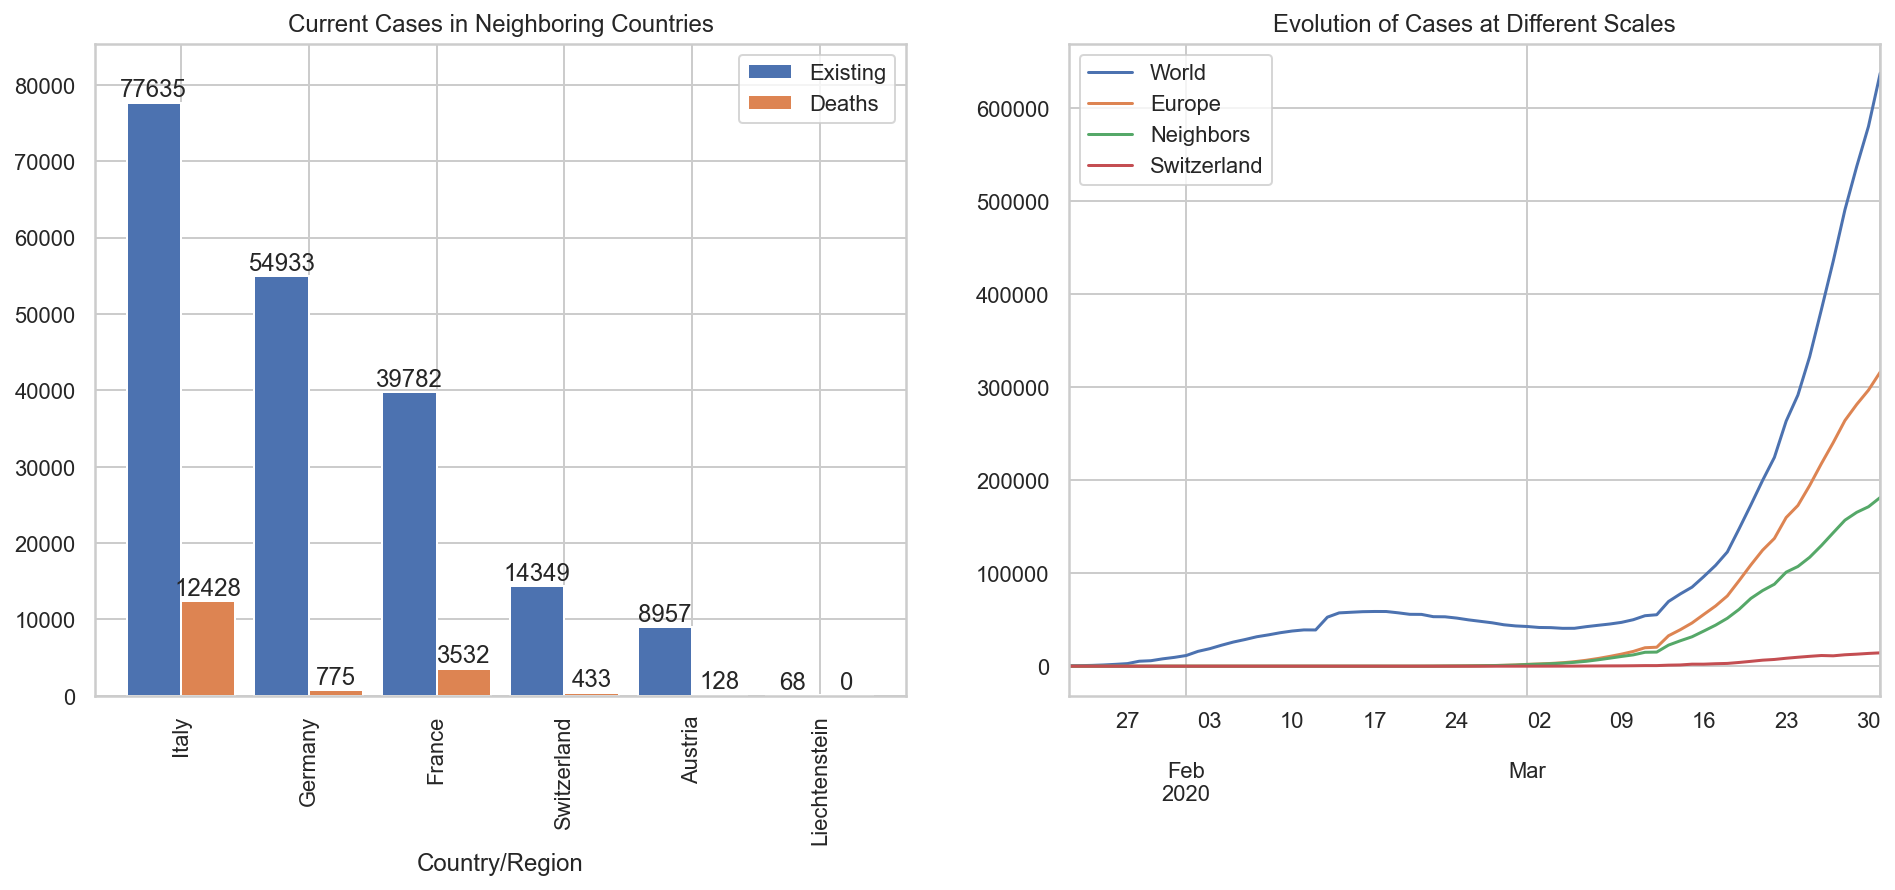

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.grid(True)
ax1.set_ymargin(0.1)
df.plot.bar(title="Current Cases in Neighboring Countries", 
            ax=ax1, 
            width=0.85,
            figsize=(16,6));
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), 
                 (p.get_x()+p.get_width()/2, p.get_height()+100), 
                 ha='center', 
                 va='center', 
                 xytext=(0, 6),
                 textcoords='offset points',
                 #fontweight="semibold",
                 rotation=0)

dfe = by_country["existing"]
dfe.sum(axis=1).plot(ax=ax2, title="Evolution of Cases at Different Scales");
dfe[EU].sum(axis=1).plot(ax=ax2)
dfe[CH_neighbors].sum(axis=1).plot(ax=ax2)
dfe[CH].sum(axis=1).plot(ax=ax2)

ax2.legend(["World", "Europe", "Neighbors", "Switzerland"]);

<p style="page-break-after:always;"></p>

## World

⚠️ Plot in beta ⚠️

In [16]:
# Get iso alpha-2 from coords
data_countries=df_confirmed[["Lat", "Long", "Country/Region", "Province/State"]].copy()
data_countries["latlon"] = data_countries.apply(lambda x : (x.Lat, x.Long), axis=1)
codes = rg.search(data_countries["latlon"].to_list())
data_countries=df_confirmed[["Lat", "Long", "Country/Region", "Province/State"]]
data_countries["alpha-2"] = list(map(lambda x : x["cc"], codes))

Loading formatted geocoded file...


/Users/frederic.montet/.pyenv/versions/anaconda3-2019.10/envs/co-vidis/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
# Get existing cases data and preprocess it
last_existing = by_country["existing"].tail(1).T
last_existing = last_existing.reset_index()
last_existing = last_existing.rename(columns={last_existing.columns[1] : "Cases"})
last_existing = pd.merge(last_existing, data_countries, on='Country/Region', how="outer")
last_existing = last_existing.rename(columns={'Country/Region' : "name"})
last_existing["alpha-3"] = last_existing.apply(lambda x : countrynames.to_code_3(x["alpha-2"]), axis=1)

/Users/frederic.montet/.pyenv/versions/anaconda3-2019.10/envs/co-vidis/lib/python3.7/site-packages/countrynames/__init__.py:23: ICUWarning: Install 'pyicu' for better text transliteration.
  norm = normalize(country, latinize=True)


In [18]:
# Load the map and simplify it
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gdf[(gdf.name != "Antarctica") & (gdf.name != "Fr. S. Antarctic Lands")]
gdf = gdf.to_crs("EPSG:4326")

In [19]:
# Add some iso alpha 3 corrections
# See : gdf.loc[gdf["iso_a3"]=="-99"]

idx1 = gdf.loc[gdf["name"] == "Norway"].index.values[0]
idx2 = gdf.loc[gdf["name"] == "France"].index.values[0]
idx3 = gdf.loc[gdf["name"] == "N. Cyprus"].index.values[0]
idx4 = gdf.loc[gdf["name"] == "Somaliland"].index.values[0]
idx5 = gdf.loc[gdf["name"] == "Kosovo"].index.values[0]

gdf.at[idx1, "iso_a3"] = "NOR"
gdf.at[idx2, "iso_a3"] = "FRA"
gdf.at[idx3, "iso_a3"] = "CYP"
gdf.at[idx4, "iso_a3"] = "SOM"
gdf.at[idx5, "iso_a3"] = "XKX"

In [20]:
# Add Cases data to the GeoDataFrame
last_existing = last_existing.rename(columns={"alpha-3":"iso_a3"})
gdfc = gdf.merge(last_existing, on="iso_a3", how="left")
gdfc["Cases"].fillna(value=0, inplace=True)

In [21]:
# Make the scale divisions
s_1 = mc.FisherJenks(gdfc['Cases'], k=10)
bins = list(map(round_up, s_1.bins))
scheme = mc.UserDefined(gdfc['Cases'], bins=bins)

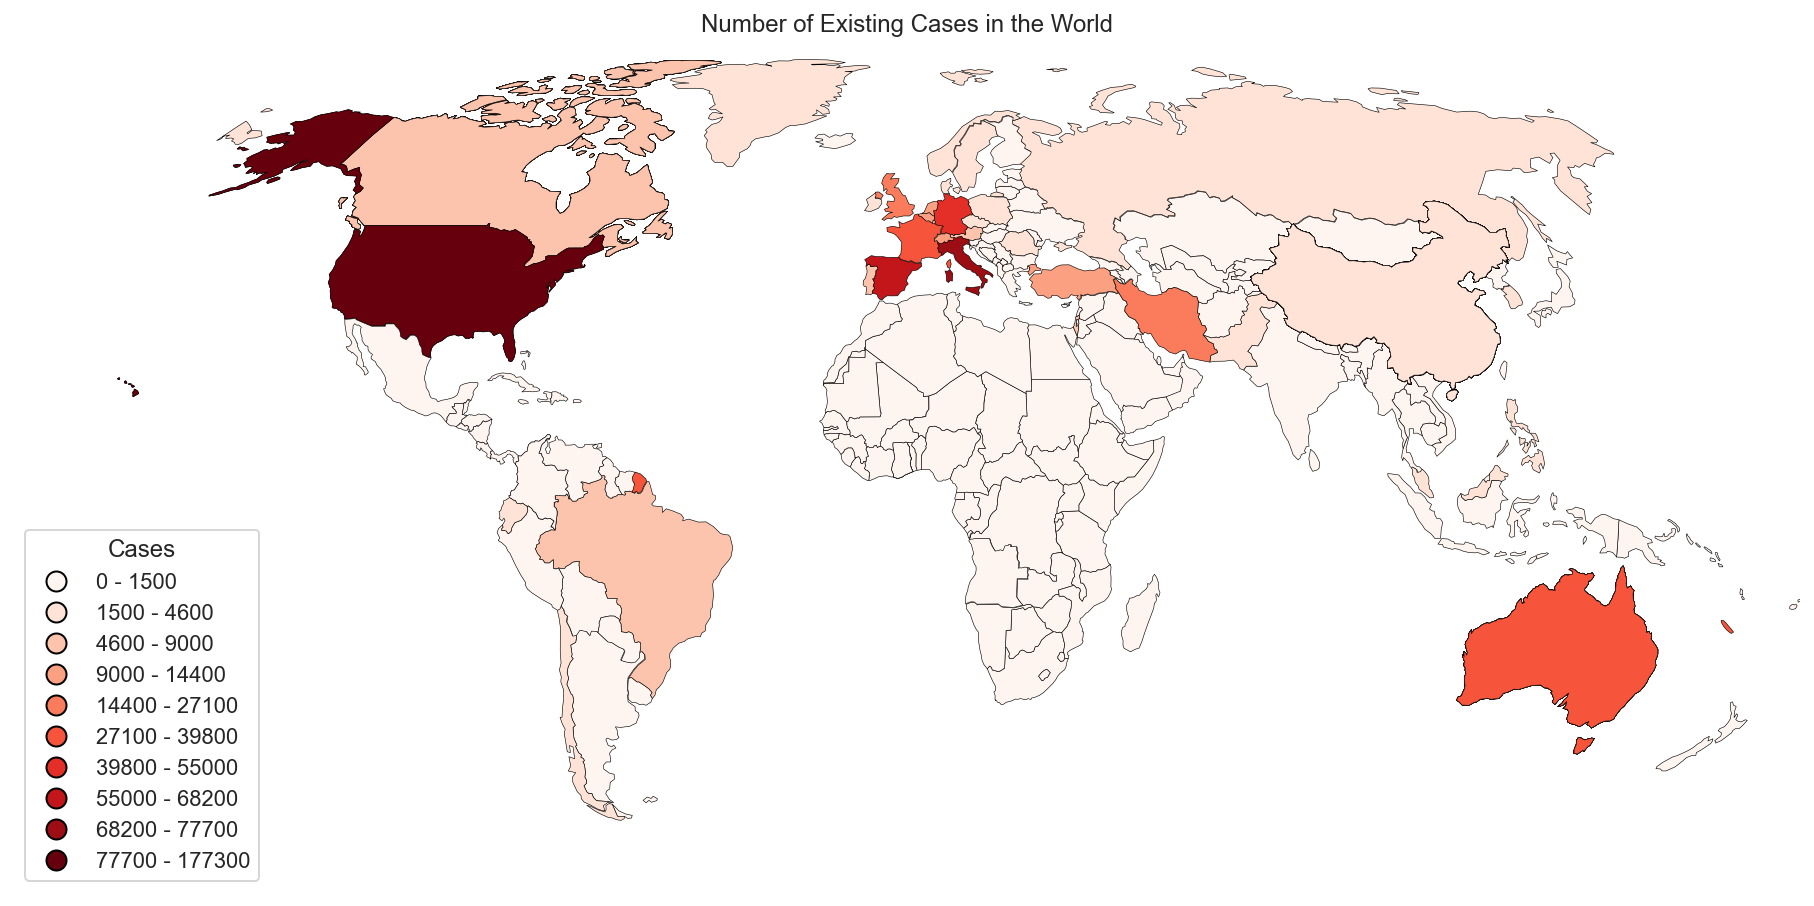

In [22]:
gplt.choropleth(gdfc,
                scheme=scheme,
                projection=gplt.crs.Robinson(), 
                hue='Cases', 
                cmap="Reds", 
                legend=True,
                figsize=(16,10),
                edgecolor="black",
                linewidth=0.3,
                legend_kwargs={
                    'title': "Cases",
                    'loc': 'lower left'}
);

plt.title("Number of Existing Cases in the World");

## About

- **Updates** : Every morning at 6:00 GMT+1 (Swiss time).
- **Author** : Fred Montet (https://twitter.com/fredmontet)
- **Repository** : https://github.com/fredmontet/co-vidis
- **Data Source** : https://github.com/CSSEGISandData/COVID-19
- **Cō Vidis?** : A word game between COVID and Quō vādis (https://en.wikipedia.org/wiki/Quo_vadis)

In [23]:
print(f"last available data : {by_country['existing'].iloc[-1].name.date()}")

last available data : 2020-03-31
